# Imports

Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
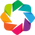

In [1]:
from utils.peak_extraction import *


# Run full pipeline

Batch1_A64.1_FOV10_1_MMStack_Default.ome has already been processed
Batch1_A64.1_FOV1_2_MMStack_Default.ome has already been processed
Batch1_A64.1_FOV2_1_MMStack_Default.ome has already been processed
Batch1_A64.1_FOV2_2_MMStack_Default.ome has already been processed
Batch1_A64.1_FOV2_3_MMStack_Default.ome has already been processed
Batch1_A64.1_FOV5_1_MMStack_Default.ome has already been processed
Batch1_A64.1_FOV6_1_MMStack_Default.ome has already been processed
Batch1_A64.1_FOV6_2_MMStack_Default.ome has already been processed
Batch1_A64.1_FOV8_1_MMStack_Default.ome has already been processed
Batch1_A64.1_FOV4_2_MMStack_Default.ome has already been processed
Batch2_64.2_FOV10_1_MMStack_Default.ome has already been processed
Batch2_64.2_FOV11_1_MMStack_Default.ome has already been processed
Batch2_64.2_FOV1_1_MMStack_Default.ome has already been processed
Batch2_64.2_FOV2_1_MMStack_Default.ome has already been processed
Batch2_64.2_FOV3_1_MMStack_Default.ome has already been process

100%|██████████| 153/153 [00:04<00:00, 32.84it/s]
c:\Users\Sudhof Lab\Desktop\fluorescent_peak_analysis\utils\analyze_data.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_conditions['agg_condition'] = removed_conditions['experiment_id'] + removed_conditions['condition']
c:\Users\Sudhof Lab\Desktop\fluorescent_peak_analysis\utils\analyze_data.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=experiment_avg_peak_amplitudes, x='condition', y='peak_absolute_amplitude', palette=group_palette)


Keeping 2188 ROIs out of 5869
Noise cutoffs are 0.02072947545526268 and 0.026739429185325105
Experiments with less than 3 ROIs: ['Batch1_64.2_FOV8_1' 'Batch3_64.2_FOV2_1' 'Batch3_64.2_FOV4_1'
 'Batch3_64.2_FOV5_1' 'Batch1_65.1_FOV1_1' 'Batch1_65.1_FOV2_1'
 'Batch1_65.1_FOV7_1' 'Batch2_65.1_FOV10_1' 'Batch2_65.1_FOV5_1'
 'Batch2_65.1_FOV8_1' 'Batch3_65.1_FOV1_1' 'Batch2_66.1_FOV4_1'
 'Batch1_77.54_FOV10_1' 'Batch1_77.54_FOV1_1' 'Batch1_77.54_FOV7_1'
 'Batch1_77.54_FOV8_1']
Removed the following experiments completely: ['Batch1_64.2_FOV5_164.2' 'Batch1_64.2_FOV8_164.2'
 'Batch2_64.2_FOV1_164.2' 'Batch2_64.2_FOV2_164.2'
 'Batch2_64.2_FOV7_164.2' 'Batch2_64.2_FOV8_164.2'
 'Batch3_64.2_FOV10_164.2' 'Batch3_64.2_FOV2_164.2'
 'Batch3_64.2_FOV3_164.2' 'Batch3_64.2_FOV4_164.2'
 'Batch3_64.2_FOV5_164.2' 'Batch3_64.2_FOV6_164.2'
 'Batch3_64.2_FOV7_164.2' 'Batch1_65.1_FOV1_165.1'
 'Batch1_65.1_FOV2_165.1' 'Batch1_65.1_FOV7_165.1'
 'Batch2_65.1_FOV10_165.1' 'Batch2_65.1_FOV4_165.1'
 'Batch2_65.1_FO

c:\Users\Sudhof Lab\Desktop\fluorescent_peak_analysis\utils\analyze_data.py:179: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=roi_avg_peak_amplitudes, x='condition', y='peak_absolute_amplitude', palette=group_palette)
c:\Users\Sudhof Lab\Desktop\fluorescent_peak_analysis\utils\analyze_data.py:185: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
c:\Users\Sudhof Lab\Desktop\fluorescent_peak_analysis\utils\analyze_data.py:191: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()
c:\Users\Sudhof Lab\Desktop\fluo

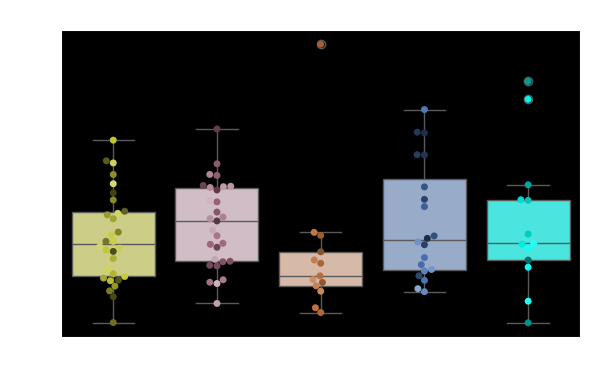

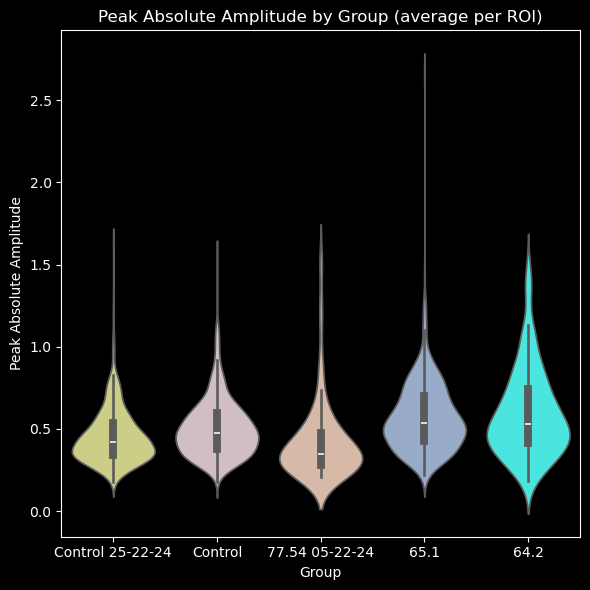

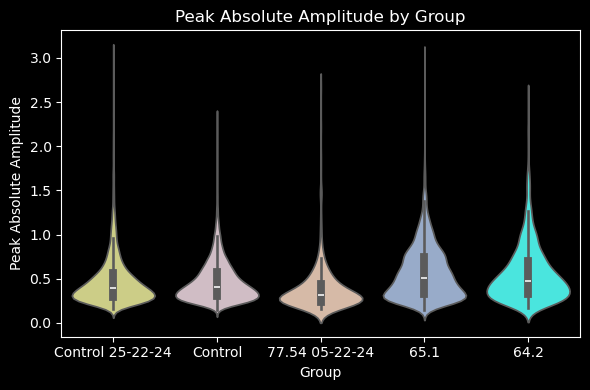

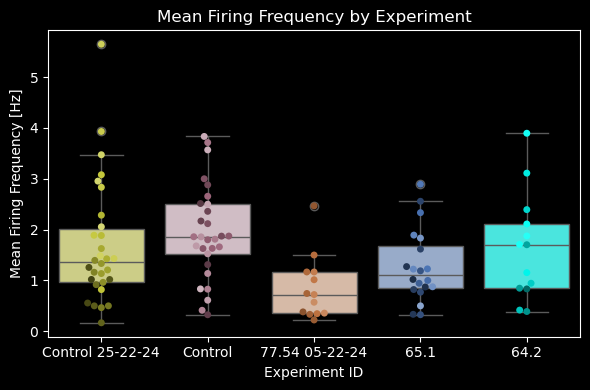

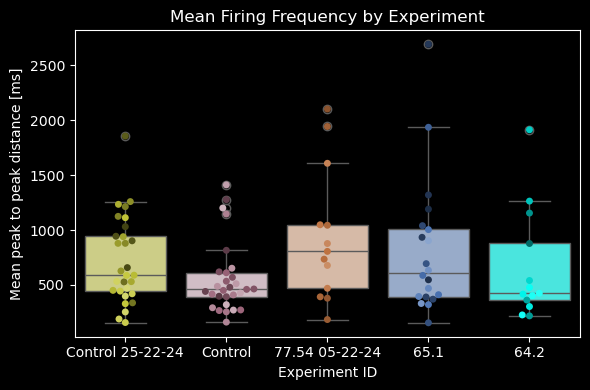

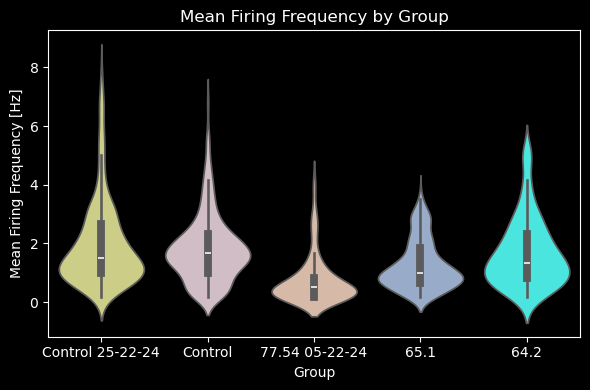

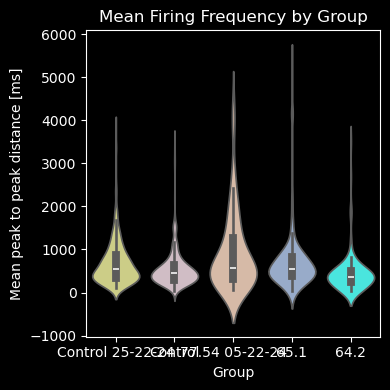

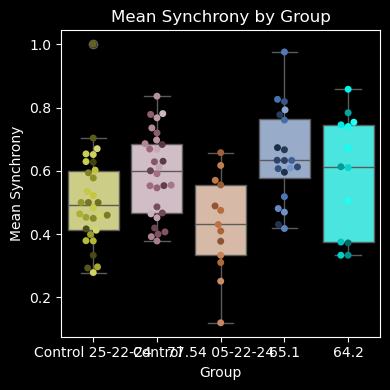

In [2]:
input_dir = 'i:\Live Imaging\Kif\Round1'
output_dir = 'i:\Live Imaging\Output_Kif'

process_dataset(input_dir, output_dir)


# Older functions for tests and debugging

In [144]:
#get the experiment ids that are present in experiment_avg_firing_frequency, but not in experiment_avg_peak_amplitudes
missing_combinations = experiment_avg_firing_frequency[~experiment_avg_firing_frequency.set_index(['experiment_id']).index.isin(experiment_avg_peak_amplitudes.set_index(['experiment_id']).index)]
print(f"Missing combinations: {missing_combinations}")

#Check how many rows in experiment_avg_firing_frequency have NaN values
nan_rows_amplitude = experiment_avg_peak_amplitudes[experiment_avg_peak_amplitudes.isnull().any(axis=1)]
nan_rows_frequency = experiment_avg_firing_frequency[experiment_avg_firing_frequency.isnull().any(axis=1)]
nan_rows_synchrony = mean_synchrony_df[mean_synchrony_df.isnull().any(axis=1)]
print(f"Rows with NaN values: {nan_rows_amplitude.shape[0]}") 
print(f"Rows with NaN values: {nan_rows_frequency.shape[0]}")
print(f"Rows with NaN values: {nan_rows_synchrony.shape[0]}")

print(experiment_avg_peak_amplitudes.shape[0])
print(experiment_avg_firing_frequency.shape[0])
print(mean_synchrony_df.shape[0])


Missing combinations: Empty DataFrame
Columns: [experiment_id, mean_firing_frequency[Hz], mean_peak_to_peak_distance[ms], group]
Index: []
Rows with NaN values: 4
Rows with NaN values: 8
Rows with NaN values: 0
136
136
136


# Check if metrics are related

In [113]:
experiment_avg_peak_amplitudes.head()

,experiment_id,peak_absolute_amplitude,peak_relative_amplitude,group
117,Batch127_ApoE4_FOV9.DFF,1.701753,0.696373,ApoE4
116,Batch127_ApoE4_FOV6.DFF,1.860093,0.854574,ApoE4
115,Batch127_ApoE4_FOV5.DFF,1.439130,0.433140,ApoE4
114,Batch127_ApoE4_FOV4.DFF,1.398785,0.390678,ApoE4
113,Batch127_ApoE4_FOV3.DFF,1.436458,0.402062,ApoE4


In [114]:
experiment_avg_firing_frequency.head()

,experiment_id,mean_firing_frequency[Hz],mean_peak_to_peak_distance[ms],group
117,Batch127_ApoE4_FOV9.DFF,0.781421,1102.532475,ApoE4
116,Batch127_ApoE4_FOV6.DFF,1.034884,1107.395755,ApoE4
115,Batch127_ApoE4_FOV5.DFF,1.480480,665.288860,ApoE4
114,Batch127_ApoE4_FOV4.DFF,1.191176,863.987953,ApoE4
113,Batch127_ApoE4_FOV3.DFF,1.333333,805.976190,ApoE4


In [115]:
mean_synchrony_df.head()

,experiment_id,group,synchrony
117,Batch127_ApoE4_FOV9.DFF,ApoE4,0.895900
116,Batch127_ApoE4_FOV6.DFF,ApoE4,0.951364
115,Batch127_ApoE4_FOV5.DFF,ApoE4,0.804944
114,Batch127_ApoE4_FOV4.DFF,ApoE4,0.751276
113,Batch127_ApoE4_FOV3.DFF,ApoE4,1.000000


<Axes: xlabel='peak_absolute_amplitude', ylabel='mean_firing_frequency[Hz]'>

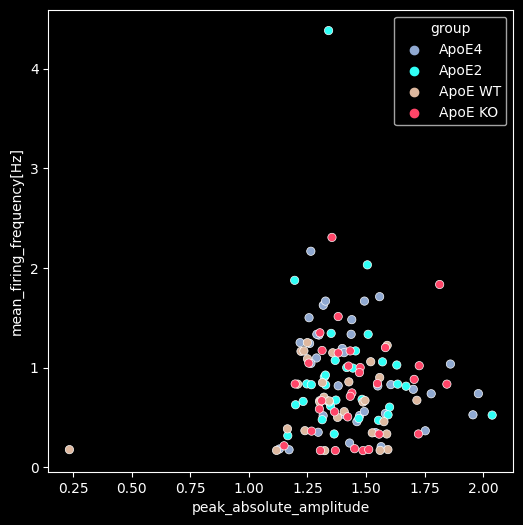

In [116]:
# Merge experiment_avg_peak_amplitudes, experiment_avg_firing_frequency, and mean_synchrony_df on experiment_id
per_experiment_metrics = experiment_avg_peak_amplitudes.merge(experiment_avg_firing_frequency, on='experiment_id').merge(mean_synchrony_df, on='experiment_id')
# Plot a scatter plot of peak amplitudes vs firing frequency
plt.figure(figsize=(6, 6))
sns.scatterplot(data=per_experiment_metrics, x='peak_absolute_amplitude', y='mean_firing_frequency[Hz]', hue='group', palette=group_palette)

<Axes: xlabel='peak_absolute_amplitude', ylabel='synchrony'>

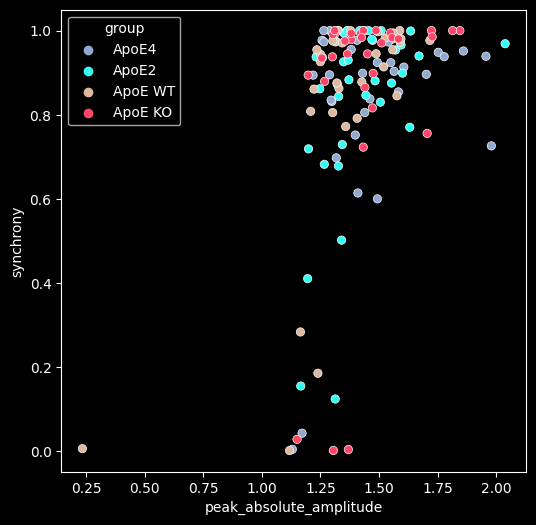

In [117]:
#Plot a scatter plot of peak amplitudes vs synchrony
plt.figure(figsize=(6, 6))
sns.scatterplot(data=per_experiment_metrics, x='peak_absolute_amplitude', y='synchrony', hue='group', palette=group_palette)


<Axes: xlabel='mean_firing_frequency[Hz]', ylabel='synchrony'>

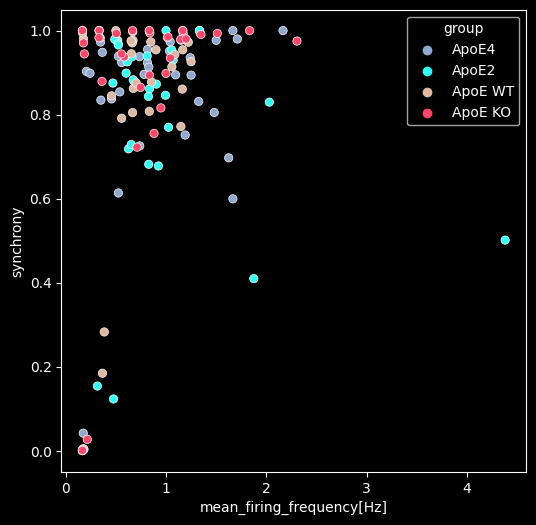

In [118]:
#Plot a scatter plot of firing frequency vs synchrony
plt.figure(figsize=(6, 6))
sns.scatterplot(data=per_experiment_metrics, x='mean_firing_frequency[Hz]', y='synchrony', hue='group', palette=group_palette)

# Look at peak height distribution

In [ ]:
experiment_id = 'Batch124_ApoE2_FOV1.DFF'
data_path = 'data'
experiment_path = join(data_path, experiment_id)

array, df = load_data(join(data_path, experiment_id + '.txt'))
experiment_df = pd.read_csv(join(experiment_path, experiment_id + '_experiment_df.csv'))
experiment_df.head()

experiment_df['noise_level'] = experiment_df['roi_id'].apply(lambda x: calc_noise_levels(array, int(x.rsplit('ROI')[1]) - 1))
    

experiment_df.head()

,roi_id,peak_time,peak_absolute_amplitude,peak_relative_amplitude,noise_level
0,ROI1,428,1.545500,0.523404,0.010076
1,ROI1,827,1.350890,0.328794,0.010076
2,ROI1,2369,1.677700,0.655604,0.010076
3,ROI1,2598,1.086602,0.064506,0.010076
4,ROI1,2959,1.145090,0.122994,0.010076


In [63]:
#For all individual experiments, plot the noise level histogram in different colors
fig = go.Figure()
for experiment_id in experiments_amplitude_df['experiment_id'].unique():
    experiment_df_subset = experiments_amplitude_df[experiments_amplitude_df['experiment_id'] == experiment_id]
    fig.add_trace(go.Histogram(x=experiment_df_subset['noise_level'], nbinsx=50, name=experiment_id))

fig.update_layout(title='Noise Level Distribution by Experiment', xaxis_title='Noise Level', yaxis_title='Count')
#Makee the plot dark
fig.update_layout(template='plotly_dark')
#Use experiment_palette to color the histogram bars
for i, experiment_id in enumerate(experiments_amplitude_df['experiment_id'].unique()):
    fig.data[i].marker.color = experiment_palette[experiment_id]
#Add vertical lines at noise cutoffs
fig.add_vline(x=mean_noise - 1 * std_noise, line_dash='dash', line_color='gray', annotation_text='-1 STD')
fig.add_vline(x=mean_noise + 1 * std_noise, line_dash='dash', line_color='gray', annotation_text='+1 STD')
fig.add_vline(x=mean_noise - 2 * std_noise, line_dash='dash', line_color='gray', annotation_text='-2 STD')
fig.add_vline(x=mean_noise + 2 * std_noise, line_dash='dash', line_color='gray', annotation_text='+2 STD')

fig.show()
#Save as html
fig.write_html('noise_level_histogram_by_experiment.html')


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Loop through each experiment and add a normalized histogram trace
for experiment_id in experiments_amplitude_df['experiment_id'].unique():
    experiment_df_subset = experiments_amplitude_df[experiments_amplitude_df['experiment_id'] == experiment_id]
    fig.add_trace(
        go.Histogram(
            x=experiment_df_subset['noise_level'],
            nbinsx=50,
            name=experiment_id,
            histnorm='percent'  # Normalize to percentage
        )
    )

# Update layout for a dark theme and axis labels
fig.update_layout(
    title='Noise Level Distribution by Experiment',
    xaxis_title='Noise Level [dF/F]',
    yaxis_title='Percentage of ROIs',
    template='plotly_dark'
)
for i, experiment_id in enumerate(experiments_amplitude_df['experiment_id'].unique()):
    fig.data[i].marker.color = experiment_palette[experiment_id]

#Add vertical lines at noise cutoffs
fig.add_vline(x=mean_noise - 1 * std_noise, line_dash='dash', line_color='gray', annotation_text='-1 STD')
fig.add_vline(x=mean_noise + 1 * std_noise, line_dash='dash', line_color='gray', annotation_text='+1 STD')
fig.add_vline(x=mean_noise - 2 * std_noise, line_dash='dash', line_color='gray', annotation_text='-2 STD')
fig.add_vline(x=mean_noise + 2 * std_noise, line_dash='dash', line_color='gray', annotation_text='+2 STD')

fig.show()
#Save as html
fig.write_html('noise_level_histogram_by_experiment_normalized.html')


In [ ]:
#Plot a histogram of the noise levels using plotly
fig = go.Figure()
fig.add_trace(go.Histogram(x=experiment_df['noise_level'], nbinsx=50))
fig.update_layout(title='Noise Level Distribution', xaxis_title='Noise Level', yaxis_title='Count')
#Makee the plot dark
fig.update_layout(template='plotly_dark')
fig.show()

In [48]:
mean_noise_level = experiment_df['noise_level'].mean()

below_mean_subset = experiment_df[experiment_df['noise_level'] < mean_noise_level]
above_mean_subset = experiment_df[experiment_df['noise_level'] >= mean_noise_level]

In [49]:
#Plot a histogram of the peak heights
fig = go.Figure()
# fig.add_trace(go.Histogram(x=experiment_df['peak_absolute_amplitude'], nbinsx=25, name='Lower noise ROIs'))
fig.add_trace(go.Histogram(x=below_mean_subset['peak_absolute_amplitude'], nbinsx=25, name='Lower noise ROIs'))
fig.add_trace(go.Histogram(x=above_mean_subset['peak_absolute_amplitude'], nbinsx=25, name='Higher noise ROIs'))
# fig.update_layout(title='Peak Heights Histogram', xaxis_title='Peak Height [dF/F]', yaxis_title='Count')
#Make the plot dark
fig.update_layout(template='plotly_dark')
# fig.write_html(os.path.join(data_output_dir, 'peak_heights_histogram.html'))
fig.write_image(os.path.join('peak_heights_histogram.pdf'), format='pdf')
fig.show()

## Highlight increase in noise with ROI id increase

In [111]:
#Plot traces 0 and 78
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=np.arange(array.shape[0]), y=array[:, 78], name='ROI 78'))
# fig.add_trace(go.Scatter(x=np.arange(array.shape[0]), y=array[:, 0], name='ROI 0'))
# fig.update_layout(title='Raw Signal Traces', xaxis_title='Time', yaxis_title='Intensity')
# fig.show()

#Now plot the same thing but so that it can be pasted onto black background
fig = go.Figure()
#Create an array for the x axis corresponding to np.arange(array.shape[0]), but in units of seconds rather than ms
x_arr = np.arange(array.shape[0]) / 100
fig.add_trace(go.Scatter(x=x_arr, y=array[:, 78], name='ROI 79'))
fig.add_trace(go.Scatter(x=x_arr, y=array[:, 0], name='ROI 1'))
fig.update_layout(xaxis_title='Time [s]', yaxis_title='Intensity [dF/F]', plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
fig.show()
#Also export as html, pdf, and png
output_file_root = os.path.join(data_output_dir, 'sample_trace_plot')
fig.write_html(output_file_root + '.html')
fig.write_image(output_file_root + '.pdf', format='pdf')
fig.write_image(output_file_root + '.png', format='png')

In [46]:
plot_noise_level(array)

# Visualize matlab-based ROIs

In [ ]:
from scipy.io import loadmat
import numpy as np
import napari
import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import params as params

# dataset dependent parameters
fr = 1000                             # imaging rate in frames per second
decay_time = 0.002                    # Length of a typical transient in seconds (see source/Getting_Started.rst)

# motion correction parameters
strides = (48, 48)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)         # overlap between patches (size of patch strides+overlaps)
max_shifts = (6, 6)         # maximum allowed rigid shifts (in pixels)
max_deviation_rigid = 3     # maximum shifts deviation allowed for patch with respect to rigid shifts
pw_rigid = True             # flag for performing non-rigid motion correction

# parameters for source extraction and deconvolution
p = 0                       # order of the autoregressive system
gnb = 2                     # number of global background components
merge_thr = 0.5            # merging threshold, max correlation allowed
rf =  12                  # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
stride_cnmf = None          # amount of overlap between the patches in pixels
K = 90                      # number of components per patch
method_init = 'graph_nmf'   # initialization method (you could also use 'sparse_nmf' for dendritic data)
alpha = 0.5                 # sparsity regularizer term (default is 0.5): used only for sparse_nmf
ssub = 1                    # spatial subsampling during initialization
tsub = 1                    # temporal subsampling during initialization

opts_dict = {'fnames': fnames,
            'fr': fr,
            'decay_time': decay_time,
            'strides': strides,
            'overlaps': overlaps,
            'max_shifts': max_shifts,
            'max_deviation_rigid': max_deviation_rigid,
            'pw_rigid': pw_rigid,
            'p': p,
            'nb': gnb,
            'rf': rf,
            'K': K, 
            'stride': stride_cnmf,
            'method_init': method_init,
            'alpha_snmf': alpha,  # used only for sparse_nmf
            'rolling_sum': True,
            'only_init': True,
            'ssub': ssub,
            'tsub': tsub,
            'merge_thr': merge_thr}

opts = params.CNMFParams(params_dict=opts_dict)

In [ ]:
from skimage import measure, io
import seaborn as sns

#Load matlab file with ROIs (128x128xNc)

mat = loadmat('/home/kirill/Downloads/Batch126_ApoE4_FOV5_masks.mat')
ROIs = np.array(mat['spatial'])

fnames = ['/mnt/a5e90321-8b33-423f-ad87-3e20a7c42f90/glutamate_data/ApoE iGluSnFr3/ApoE4/Batch126_ApoE4_FOV5_1/Batch126_ApoE4_FOV5_1_MMStack_Default.ome.tif']
if 'dview' in locals():  # locals contains list of current local variables
    print('Closing previous cluster')
    cm.stop_server(dview=dview)
print("Setting up new cluster")
c, dview, n_processes = cm.cluster.setup_cluster(backend='multiprocessing', 
                                                 n_processes=48,  # set to less than cpu_count-1 if you have memory problems
                                                 single_thread=False,
                                                 ignore_preexisting=False)

mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
mc.motion_correct(save_movie=True)
border_to_0 = 0 if mc.border_nan == 'copy' else mc.border_to_0 
# memory map the file in order 'C'
fname_new = cm.save_memmap(mc.mmap_file, base_name='memmap_', order='C',
                           border_to_0=border_to_0) # exclude borders

# now load the file
Yr, dims, T = cm.load_memmap(fname_new)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 

CI = cm.local_correlations(images[::1].transpose(1,2,0))

#Create a new array with the same shape as a single frame
# Extract contours for each mask
contours = []

mat_labels = np.zeros(shape=[ROIs.shape[0], ROIs.shape[1]])
#For each mask in the third dimension of ROIs set the corresponding pixels in mat_labels to the mask number
for i in range(ROIs.shape[2]):
    slice = ROIs[:,:,i]
    # Find contours at the 0.5 level
    raw_contours = measure.find_contours(slice, level=0.5)
    # Add each contour as an array to the list
    contours.extend(raw_contours)

# Visualize with napari
viewer = napari.Viewer()
viewer.add_image(
    CI,
    name="Average Image",
    colormap='gray',
    opacity=0.8
)

num_contours = len(contours)

#Create num_contours hex colors
colors = sns.color_palette("hsv", num_contours)

#Shuffle colors
np.random.shuffle(colors)

# Add the contours to the viewer as shapes
viewer.add_shapes(contours,
                  shape_type='path',
                  edge_color=colors,
                  edge_width=0.5,
                  name='Contours')
napari.run()